In [7]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Reference image from Zemax

Parabolic mirror RC with monochromatic 600nm on-axis source.

Data spacing is 1.875 µm.
Data area is 1920.027 by 1920.027 µm.
Center point is: 513, 513

In [2]:
import numpy as np
import os

# Source file location
datapath = '../zemax_examples/'
filename = 'toliman-RC-f50_ParaxialVersion_psf_0deg_600nm.npy'

zemax_ref = np.load(datapath+filename)

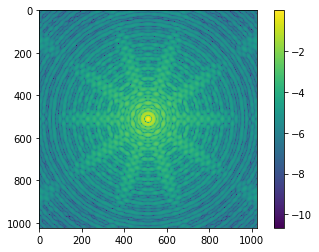

In [4]:
# Check it looks OK
import matplotlib.pyplot as plt
plt.imshow(np.log10(zemax_ref), cmap='viridis')
plt.colorbar()
plt.show()

In [11]:
import proper
# Resolution is too high, so downsample.
src_pitch = 1.875e-6 # m/pixel
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

mag = src_pitch / detector_pitch
print("Rescaling from sampling of {} to {}, magnification of {}".format(src_pitch, detector_pitch, mag))
zemax_resized = proper.prop_magnify(zemax_ref, mag, CONSERVE = False)

Rescaling from sampling of 1.875e-06 to 1.1e-05, magnification of 0.17045454545454547


(174, 174)


/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


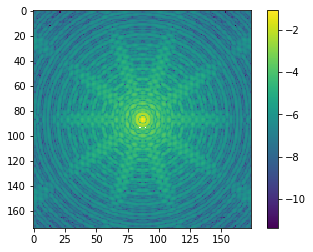

In [18]:
# Normalise
sz = zemax_resized.shape
zemax_resized /= zemax_resized.sum(axis=None)

print(sz)
plt.imshow(np.log10(zemax_resized), cmap='viridis')
plt.colorbar()
plt.show()

## Calculated PSF from PROPER

In [5]:
import numpy as np

toliman_settings = {
                    # Eduardo's values:
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 0.5717255, 
                    'm1_m2_sep': 0.54933763033373, 
                    'm2_fl': -0.02337895948640,  
                    'bfl': 0.52761,#0.58999999998985,  
                    'm2_rad': 0.00590401477581,
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': 0.2,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00
                    }

gridsize = 2048 # sampling of wavefront

n_wavelengths = 5
# First source, on axis
source_a = {
            'wavelengths': [0.6],
            'weights': [1.],
            'settings': toliman_settings
            }


In [ ]:
# Calculated PSF
from proper_tools import form_detector_image

detector_image = form_detector_image('prescription_rc_quad', [source_a], gridsize, detector_pitch, sz[0])


/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


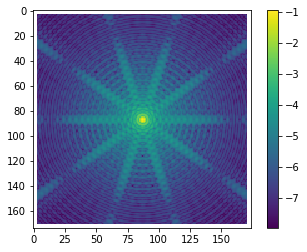

In [19]:
detector_image /= detector_image.sum(axis=None)
plt.imshow(np.log10(detector_image), interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.show()


/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


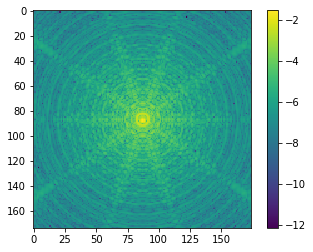

In [21]:
diff = detector_image - zemax_resized
plt.imshow(np.log10(np.abs(diff)), interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.show()

## Fit by tweaking telescope magnification